In [1]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure, homogeneity_score, completeness_score, v_measure_score
from scikitplot.metrics import plot_silhouette
from scikitplot.cluster import plot_elbow_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('data-btc-daily.csv')
#data.drop('Date.1',axis=1,inplace=True)
data.index = pd.DatetimeIndex(data['Date'])
data.drop('Date',axis=1,inplace=True)

In [4]:
data.shape

(1842, 61)

In [5]:
data['Return_4d'] = data['Close'].pct_change(6).shift(-7)
data['BuyorSell'] = [-1 if x <= 0 else 1 for x in data['Return_4d']]
data.dropna(axis=0,inplace=True)

In [6]:
#Including flat return to negative return class
data['BuyorSell'].fillna(0,inplace=True)

In [7]:
#Creates new moving averages
def EMAS_TA(df,col,ma1,ma2):
    if (type(ma1) or type(ma2)) != int:
        print('ma1 and ma2 are not integer')
    elif ma1 > ma2:
        print('ma1 needs to be smaller than ma2')
    else:
        a = col + '_' + str(ma1) + 'MA'
        b = col + '_' + str(ma2) + 'MA'
        df[a] = df[col].ewm(span=ma1,adjust=True).mean()
        df[b] = df[col].ewm(span=ma2,adjust=True).mean()
        c = 'diff' + str(a) + '_' + str(b) 
        df[c] = df[b] - df[a]
    return

In [8]:
#create exp moving average for 1 week vs 2 weeks
EMAS_TA(data,'Close',50,100)

In [9]:
#New features
data['Diff_Close_Open'] = data.Close - data.Open
data['Diff_Close_avg'] = data.Close - data.avg

In [10]:
data.dropna(axis=0,inplace=True)

In [11]:
#other features, position of Close price vs moving averages
data['Dist_Close_STmas'] = data.Close - data.Close_7MA
data['Dist_Close_LTmas'] = data.Close - data.Close_14MA

In [6]:
#Check relationship between chosen features
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=data,x='ATR', y='Dist_BolDn_BolUp',ax=ax)
plt.show()

NameError: name 'plt' is not defined

In [13]:
y = data['BuyorSell'].copy()

In [15]:
#Use any features you want from the columns'name.
X = data[['Diff_Close_14EMAClose_7EMA','RSI_Close',
       'Close_MAs_ratio', 'DnBol_Dist_14', 'UpBol_Dist_14',
       'ATR',
       'diffClose_50MA_Close_100MA']].copy()


In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr())#,annot=True)

NameError: name 'plt' is not defined

In [20]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
Xstd = scaler2.fit_transform(X)

In [7]:
knn = KMeans(n_clusters=3, random_state=1)
plot_elbow_curve(knn, Xstd, cluster_ranges=range(1, 11))
plt.show()

NameError: name 'KMeans' is not defined

In [22]:
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from tqdm import tqdm

In [8]:
#Looking at clustering model to see if some patterns emerge. Ideally I am selecting features so the model can clustering 
# support and resistance

silhouette = []

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 30))

for k in tqdm(range(2, 6)):

    model = KMeans(n_clusters=k, random_state=1)
    labels = model.fit_predict(Xstd)
    silhouette.append((k, silhouette_score(Xstd, labels)))

    colors = cm.nipy_spectral(labels.astype(float) / k)
    plot_silhouette(Xstd, labels, ax=ax[k-2, 0])
    ax[k-2, 1].scatter(Xstd[:, 0], Xstd[:, 1], color=colors)

silhouette = np.array(silhouette)

NameError: name 'plt' is not defined

In [24]:
model = KMeans(n_clusters=2, random_state=1)
model.fit(Xstd)
labels = model.predict(Xstd)

In [25]:
df = pd.DataFrame(labels,columns=['Labels'])

In [26]:
df['Close'] = data.Close.values

In [27]:
df.set_index(data.index,inplace=True)

In [28]:
df.Labels.value_counts()

1    1015
0     806
Name: Labels, dtype: int64

In [9]:
import plotly.graph_objects as go

layout = dict(title='BTC',
              plot_bgcolor='white',
              margin=dict(t=60, b=40, l=20, r=20),
              xaxis=dict(linecolor='gray', mirror=True, showgrid=False),
              yaxis=dict(linecolor='gray', mirror=True, showgrid=False),
                                 )

Chart = []

Chart.append(go.Scatter(x=data.index,
                       y=data['Close'],
                       name='avg',
                       mode='lines',
                       line=dict(color='lime', width=1)))

#Chart.append(go.Scatter(x=data.index,
 #                      y=data['Close_60MA'],
  #                     name='60MA',
   #                    mode='lines',
    #                   line=dict(color='grey', width=1)))

Chart.append(go.Scatter(x=df.query('Labels == 2').index,
                       y=df.query('Labels == 2')['Close'],
                     name='avg, Labels = 2',
                       mode='markers',
                       marker=dict(color='purple', size=5)))

Chart.append(go.Scatter(x=df.query('Labels == 1').index,
                       y=df.query('Labels == 1')['Close'],
                       name='avg, Labels = 1',
                       mode='markers',
                       marker=dict(color='orange', size=5)))

Chart.append(go.Scatter(x=df.query('Labels == 0').index,
                       y=df.query('Labels == 0')['Close'],
                       name='avg, Labels = 0',
                       mode='markers',
                       marker=dict(color='blue', size=5)))

Chart.append(go.Scatter(x=df.query('Labels == 3').index,
                       y=df.query('Labels == 3')['Close'],
                       name='avg, Labels = 3',
                       mode='markers',
                       marker=dict(color='gold', size=5)))



fig = go.Figure(data=Chart, layout=layout)

fig.show()

NameError: name 'data' is not defined

In [10]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('Price', 'ATR','STD'), 
               row_width=[0.4, 0.4,0.97])

# Plot OHLC on 1st row
fig.add_trace(go.Scatter(x=data.index,
                       y=data['Close'],
                       name='Price',
                       mode='lines',
                       line=dict(color='lime', width=1)))

#Chart.append(go.Scatter(x=data.index,
 #                      y=data['Close_60MA'],
  #                     name='60MA',
   #                    mode='lines',
    #                   line=dict(color='grey', width=1)))

fig.add_trace(go.Scatter(x=df.query('Labels == 2').index,
                       y=df.query('Labels == 2')['Close'],
                     name='Labels = 2',
                       mode='markers',
                       marker=dict(color='red', size=5)))

fig.add_trace(go.Scatter(x=df.query('Labels == 1').index,
                       y=df.query('Labels == 1')['Close'],
                       name='Labels = 1',
                       mode='markers',
                       marker=dict(color='orange', size=5)))

fig.add_trace(go.Scatter(x=df.query('Labels == 0').index,
                       y=df.query('Labels == 0')['Close'],
                       name='Labels = 0',
                       mode='markers',
                       marker=dict(color='green', size=5)))

fig.add_trace(go.Scatter(x=df.query('Labels == 3').index,
                       y=df.query('Labels == 3')['Close'],
                       name='Labels = 3',
                       mode='markers',
                       marker=dict(color='blue', size=5)))


# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Scatter(x=data.index, y=data.ATR, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data.Close_std7, showlegend=False), row=3, col=1)

# Do not show OHLC's rangeslider plot 
fig.update_layout(height=1000, width=1000)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

NameError: name 'data' is not defined

dbscan = DBSCAN(eps=0.5, min_samples=7)
dbscan.fit(Xstd)

In [ ]:
print("Labels:")
labels_db = dbscan.labels_
print(labels)

In [ ]:
print(dbscan.core_sample_indices_)

In [ ]:
core_samples = np.zeros_like(labels_db, dtype=bool)

In [ ]:
core_samples

In [ ]:
core_samples[dbscan.core_sample_indices_] = True
core_samples

In [ ]:
print("Core samples")
print((core_samples * 1))

In [ ]:
df_dbscan = pd.DataFrame(labels_db,columns=['Labels'])
df_dbscan['Close'] = data.Close.values
df_dbscan.set_index(data.index,inplace=True)

In [ ]:
df_dbscan.Labels.value_counts()

In [ ]:
import plotly.graph_objects as go

layout = dict(title='BTC',
              plot_bgcolor='white',
              margin=dict(t=60, b=40, l=20, r=20),
              xaxis=dict(linecolor='gray', mirror=True, showgrid=False),
              yaxis=dict(linecolor='gray', mirror=True, showgrid=False))

Chart = []

Chart.append(go.Scatter(x=data.index,
                       y=data['Close'],
                       name='Close Price',
                       mode='lines',
                       line=dict(color='gold', width=1)))

#Chart.append(go.Scatter(x=data.index,
 #                      y=data['Close_60MA'],
  #                     name='60MA',
   #                    mode='lines',
    #                   line=dict(color='grey', width=1)))

#Chart.append(go.Scatter(x=df_dbscan.query('Labels == 1').index,
 #                      y=df_dbscan.query('Labels == 1')['Close'],
  #                     name='avg, Labels = 1',
   #                    mode='markers',
    #                   marker=dict(color='purple', size=8)))

#Chart.append(go.Scatter(x=df_dbscan.query('Labels == -1').index,
 #                      y=df_dbscan.query('Labels == -1')['Close'],
  #                     name='avg, Labels = 0',
   #                    mode='markers',
    #                   marker=dict(color='orange', size=8)))

#Chart.append(go.Scatter(x=df_dbscan.query('Labels == 0').index,
 #                      y=df_dbscan.query('Labels == 0')['Close'],
  #                     name='avg, Labels = 2',
   #                    mode='markers',
    #                   marker=dict(color='blue', size=8)))

fig = go.Figure(data=Chart, layout=layout)

fig.show()

In [29]:
##### Trying to model my target variable y by selecting relevant features and also adding my labels from the clustering
kf = KFold(n_splits=5, shuffle=True, random_state=7)
RFC = RandomForestClassifier(n_estimators=500,max_features=1.0,random_state=7)

In [31]:
#Use new features with X2
#daily
X2 = data[['Diff_Close_14EMAClose_7EMA','Diff_Volume_14EMAVolume_7EMA',
    'RSI_Close','Volume_ratio','DnBol_Dist_14',
    'UpBol_Dist_14','Dist_BolDn_BolUp','ATR','Dist_Close_STmas',
           'Dist_Close_LTmas','diffClose_50MA_Close_100MA']].copy()
#X2['rtn_Close_prev'] = data.rtn_Close.shift(1).fillna(0)
#X2['RSI_Close_prev'] = data.RSI_Close.diff().shift(1).fillna(0)
X2['rtn_Close_ma'] = data.rtn_Close.rolling(window=8).mean().fillna(0)

X2['Labels'] = labels
X2.shape

(1821, 13)

In [32]:
X2.Labels.value_counts()

1    1015
0     806
Name: Labels, dtype: int64

In [33]:
X2_dum = pd.get_dummies(X2,columns=['Labels'],drop_first=True)

In [34]:
y.shape

(1821,)

In [35]:
y.value_counts(normalize=True)

 1    0.571115
-1    0.428885
Name: BuyorSell, dtype: float64

In [36]:
scl1 = StandardScaler()
scl2 = MinMaxScaler()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X2_dum,y,test_size=0.3,stratify=y,random_state=7,shuffle=True)
Xstd_train1 = pd.DataFrame(scl2.fit_transform(X_train),columns=X2_dum.columns,index=X_train.index)
Xstd_test1 = pd.DataFrame(scl2.transform(X_test),columns=X2_dum.columns,index=X_test.index)

In [38]:
RFC.fit(Xstd_train1,y_train)

RandomForestClassifier(max_features=1.0, n_estimators=500, random_state=7)

In [39]:
print(RFC.score(Xstd_train1, y_train))
print(cross_val_score(RFC, Xstd_train1, y_train, cv=5).mean())
print(RFC.score(Xstd_test1, y_test))

1.0
0.7134815501003551
0.696526508226691


In [79]:
train_ = RFC.predict(Xstd_train1)
test_ = RFC.predict(Xstd_test1)
train_ = pd.DataFrame(train_,columns=['Predict'],index=X_train.index)
test_ = pd.DataFrame(test_,columns=['Predict'],index=X_test.index)

In [112]:
dftest1 = data[['Close']].copy()
dftest1.head()

,Close
Date,
2016-01-25,391.40
2016-01-26,391.54
2016-01-27,394.79
2016-01-28,379.61
2016-01-29,378.68


In [113]:
dftest = pd.concat([train_,test_],axis=0,join='outer')
last = pd.merge(dftest1,dftest,on=dftest1.index,how='inner')

In [115]:
last.set_index('key_0',inplace=True)

In [121]:
last.head()
last['True_label'] = data.BuyorSell

In [122]:
last.head()

,Close,Predict,True_label
key_0,,,
2016-01-25,391.40,-1,-1
2016-01-26,391.54,1,-1
2016-01-27,394.79,1,-1
2016-01-28,379.61,-1,1
2016-01-29,378.68,-1,1


In [11]:
import plotly.graph_objects as go

layout = dict(title='BTC',
              plot_bgcolor='white',
              margin=dict(t=60, b=40, l=20, r=20),
              xaxis=dict(linecolor='gray', mirror=True, showgrid=False),
              yaxis=dict(linecolor='gray', mirror=True, showgrid=False),
                                 )

Chart = []

Chart.append(go.Scatter(x=last.index,
                       y=last['Close'],
                       name='Price',
                       mode='lines',
                       line=dict(color='lime', width=1)))

#Chart.append(go.Scatter(x=data.index,
 #                      y=data['Close_60MA'],
  #                     name='60MA',
   #                    mode='lines',
    #                   line=dict(color='grey', width=1)))

Chart.append(go.Scatter(x=last.query('Predict == -1').index,
                       y=last.query('Predict == -1')['Close'],
                     name='Return, Labels = -1',
                       mode='markers',
                       marker=dict(color='red', size=5)))

Chart.append(go.Scatter(x=last.query('Predict == 1').index,
                       y=last.query('Predict == 1')['Close'],
                       name='Return, Labels = 1',
                       mode='markers',
                       marker=dict(color='green', size=5)))





fig = go.Figure(data=Chart, layout=layout)

fig.show()

NameError: name 'last' is not defined

In [12]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('Predict','True Label'), 
               row_width=[0.5, 1.5,1.5])

# Plot OHLC on 1st row
fig.add_trace(go.Scatter(x=last.index,
                       y=last['Close'],
                       name='Price',
                       mode='lines',
                       line=dict(color='lime', width=1)))

#Chart.append(go.Scatter(x=data.index,
 #                      y=data['Close_60MA'],
  #                     name='60MA',
   #                    mode='lines',
    #                   line=dict(color='grey', width=1)))

fig.add_trace(go.Scatter(x=last.query('Predict == -1').index,
                       y=last.query('Predict == -1')['Close'],
                     name='Predict = -1',
                       mode='markers',
                       marker=dict(color='orange', size=5)))

fig.add_trace(go.Scatter(x=last.query('Predict == 1').index,
                       y=last.query('Predict == 1')['Close'],
                       name='Predict = 1',
                       mode='markers',
                       marker=dict(color='blue', size=5)))



# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Scatter(x=last.index, y=last.Close, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=last.query('True_label == -1').index,
                       y=last.query('True_label == -1')['Close'],
                       name='True_label = -1',
                       mode='markers',
                       marker=dict(color='red', size=5)),row=2, col=1)
fig.add_trace(go.Scatter(x=last.query('True_label == 1').index,
                       y=last.query('True_label == 1')['Close'],
                       name='True_Label = 1',
                       mode='markers',
                       marker=dict(color='green', size=5)),row=2, col=1)

# Do not show OHLC's rangeslider plot 
fig.update_layout(height=1000, width=1000)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

NameError: name 'last' is not defined

In [13]:
pd.DataFrame(RFC.feature_importances_,
             columns=['importance'],
             index=X2_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).plot(kind='barh', figsize=(10, 12))
plt.show()

NameError: name 'pd' is not defined

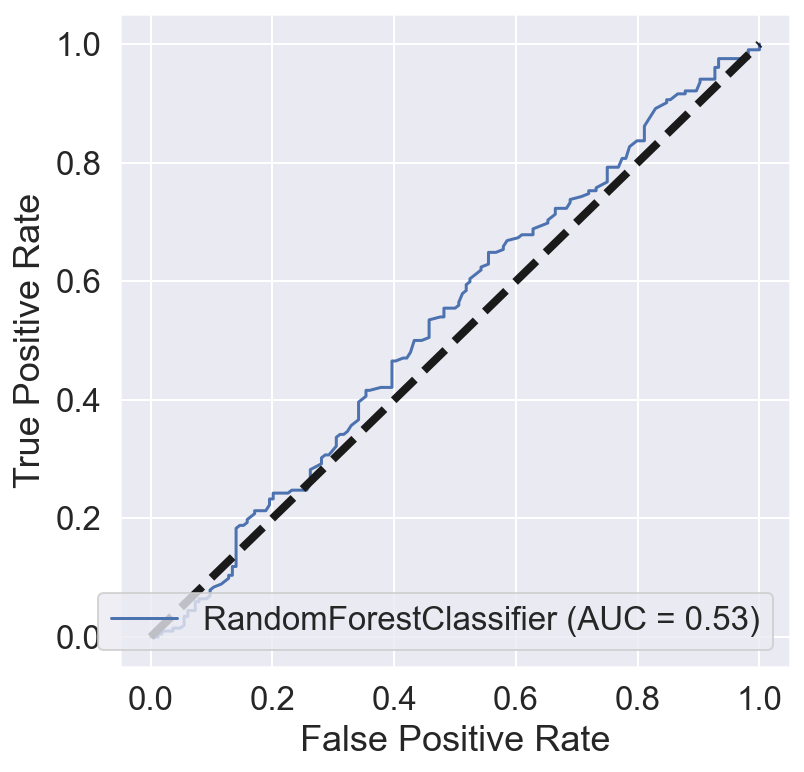

In [94]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(RFC, Xstd_test1, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

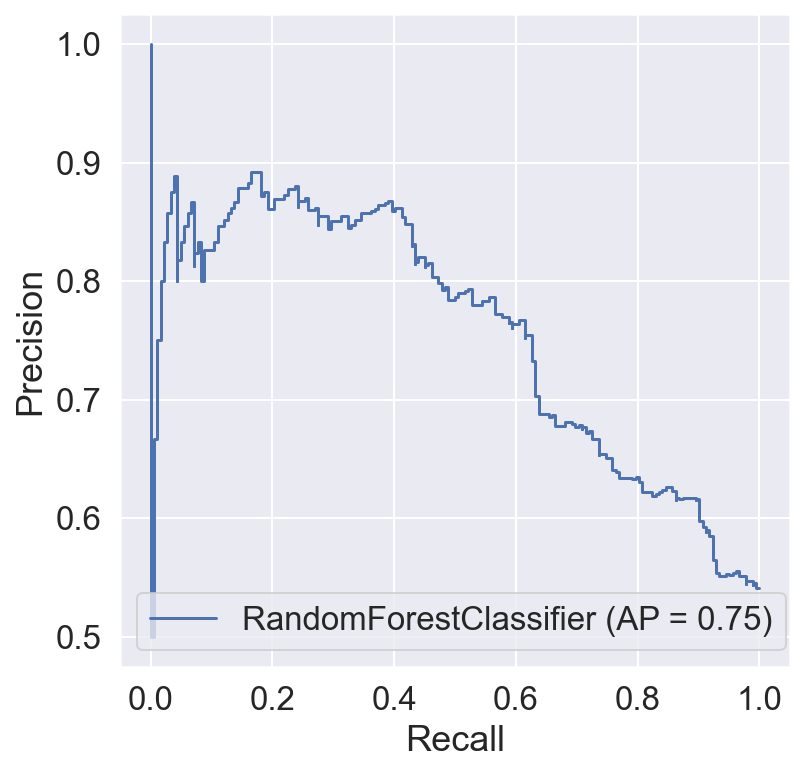

In [80]:
plt.fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(RFC, Xstd_test1, y_test, ax=ax)
plt.show()

In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, RFC.predict(Xstd_test1)))

              precision    recall  f1-score   support

          -1       0.65      0.58      0.61       157
           1       0.67      0.73      0.69       182

    accuracy                           0.66       339
   macro avg       0.66      0.65      0.65       339
weighted avg       0.66      0.66      0.66       339



In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score

In [50]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [ ]:
baggingRFC = BaggingClassifier(base_estimator=df,
                            max_samples=0.825, 
                            max_features=1.0, 
                            n_estimators=1000,
                            verbose =10)

In [ ]:
print("Bagging CV training score:\t", 
      cross_val_score(baggingRFC, Xstd_train1, y_train,
                    cv=5, n_jobs=-2).mean())

baggingRFC.fit(Xstd_train1, y_train)
print("Clf bagging training score:\t", baggingRFC.score(Xstd_train1, y_train))
print("Clf bagging test score:\t", baggingRFC.score(Xstd_test1, y_test))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(bagging, Xstd_test1, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [ ]:
baggingRFC.score(Xstd_test1, y_test)

In [ ]:
params_RFC = {'max_samples': np.linspace(0.3, 1.0, 5),
          'max_features': range(int(1/2.*Xstd_train1.shape[1]), Xstd_train1.shape[1]+1),
           'n_estimators': [100]}

grid_rfc = GridSearchCV(RFC, param_grid=params_RFC, cv=5, n_jobs=-2,verbose=10)
grid_rfc.fit(Xstd_train1, y_train)
grid_rfc.best_params_

In [ ]:
grid_rfc.best_score_

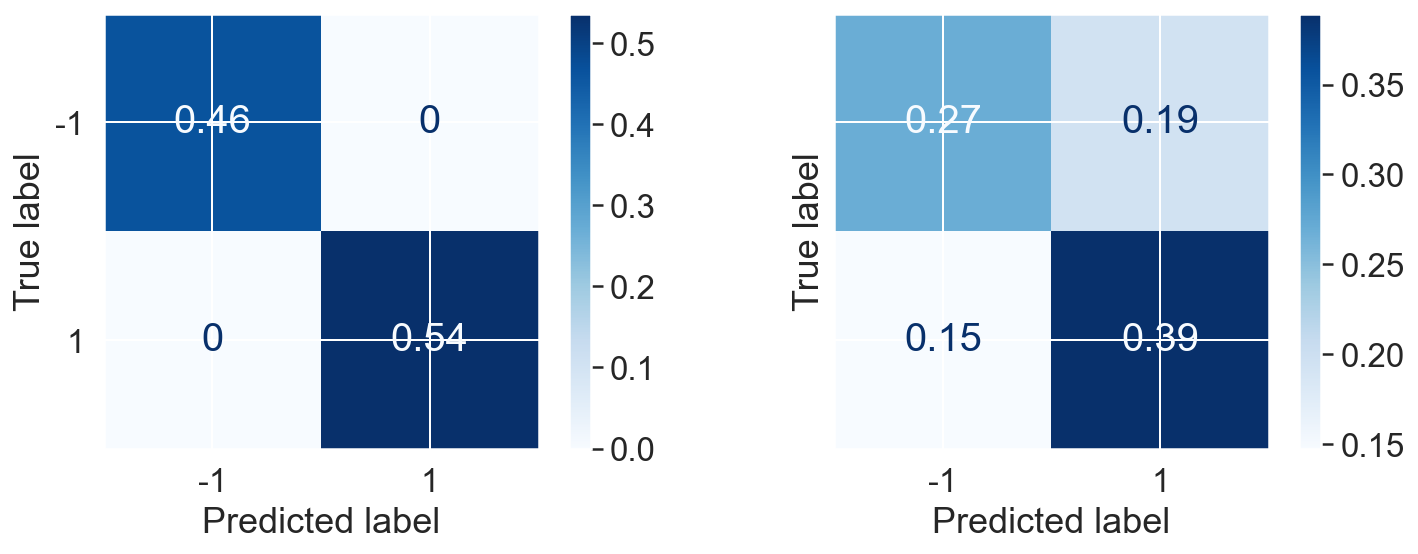

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(RFC, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(RFC, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [88]:
LogReg = LogisticRegressionCV(solver='saga')

In [90]:
bagging = BaggingClassifier(base_estimator=LogReg,
                            max_samples=0.825, 
                            max_features=1.0, 
                            n_estimators=1000,
                            verbose =10)

In [1]:
print("Bagging CV training score:\t", 
      cross_val_score(bagging, Xstd_train1, y_train,
                    cv=5, n_jobs=-2).mean())

bagging.fit(Xstd_train1, y_train)
print("Clf bagging training score:\t", bagging.score(Xstd_train1, y_train))
print("Clf bagging test score:\t", bagging.score(Xstd_test1, y_test))

NameError: name 'cross_val_score' is not defined

In [ ]:
bagging.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


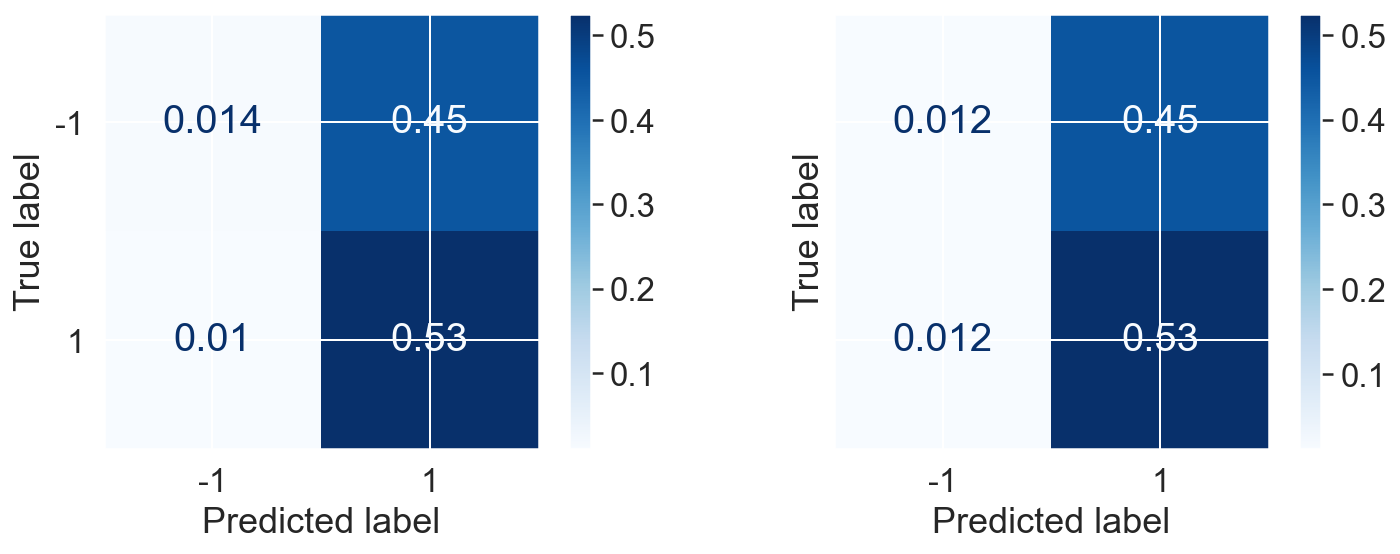

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(bagging, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(bagging, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [ ]:
params = {'max_samples': np.linspace(0.3, 1.0, 5),
          'max_features': range(int(1/2.*Xstd_train1.shape[1]), Xstd_train1.shape[1]+1),
           'n_estimators': [1000]}

grid = GridSearchCV(bagging, param_grid=params, cv=5, n_jobs=-2)
grid.fit(Xstd_train1, y_train)
grid.best_estimator_

In [ ]:
grid.best_score_

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(grid, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(grid, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [2]:
params_LogReg = {'Cs' : [np.logspace(-4, 4, 10)],
              'penalty' : ['l2','l1','elasticnet'],
              'max_iter' : [10000],
                 'l1_ratios' : [0.001, 0.01, 0.05, 0.1, 0.5]}
gs_LogReg = GridSearchCV(LogReg,params_LogReg,cv=5,verbose=10)
gs_LogReg.fit(Xstd_train1, y_train)

NameError: name 'np' is not defined

In [3]:
gs_LogReg.cv_results_

NameError: name 'gs_LogReg' is not defined

In [73]:
gs_LogReg.best_score_

0.5353999348817018

In [74]:
gs_LogReg.score(Xstd_train1,y_train)

0.556047197640118

In [75]:
gs_LogReg.score(Xstd_test1,y_test)

0.5457227138643068

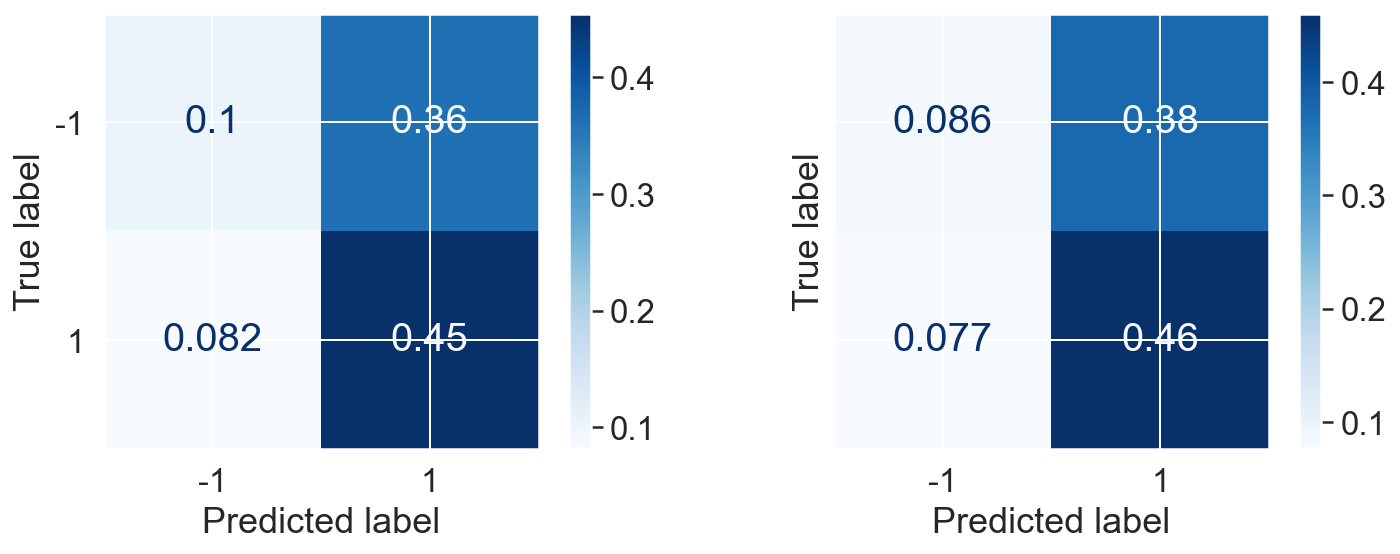

In [83]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_LogReg, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(gs_LogReg, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [93]:
from sklearn.svm import SVC, LinearSVC

In [94]:
SVC1 = LinearSVC(loss='hinge',max_iter=5000, class_weight='balanced')
SVC2 = SVC(kernel='poly',gamma='scale',class_weight='balanced')

In [95]:
params_svm = {'C': np.logspace(-2, 2, 5),
              'gamma': np.linspace(0.01, 2, 5),
              'kernel': ['poly','linear','rbf']}
params_svm_poly = {'C': np.logspace(-2, 2, 5),
              'gamma': np.linspace(0.01, 2, 5),
              'kernel': ['poly'],
            'degree' : [2,3,4]}

In [96]:
print(cross_val_score(SVC1, Xstd_train1, y_train, cv=5, scoring='accuracy').mean())
print(cross_val_score(SVC2, Xstd_train1, y_train, cv=5, scoring='accuracy').mean())

0.5206642066420664
0.5383601041892773


In [97]:
SVC1.fit(Xstd_train1, y_train)
SVC2.fit(Xstd_train1, y_train)

SVC(class_weight='balanced', kernel='poly')

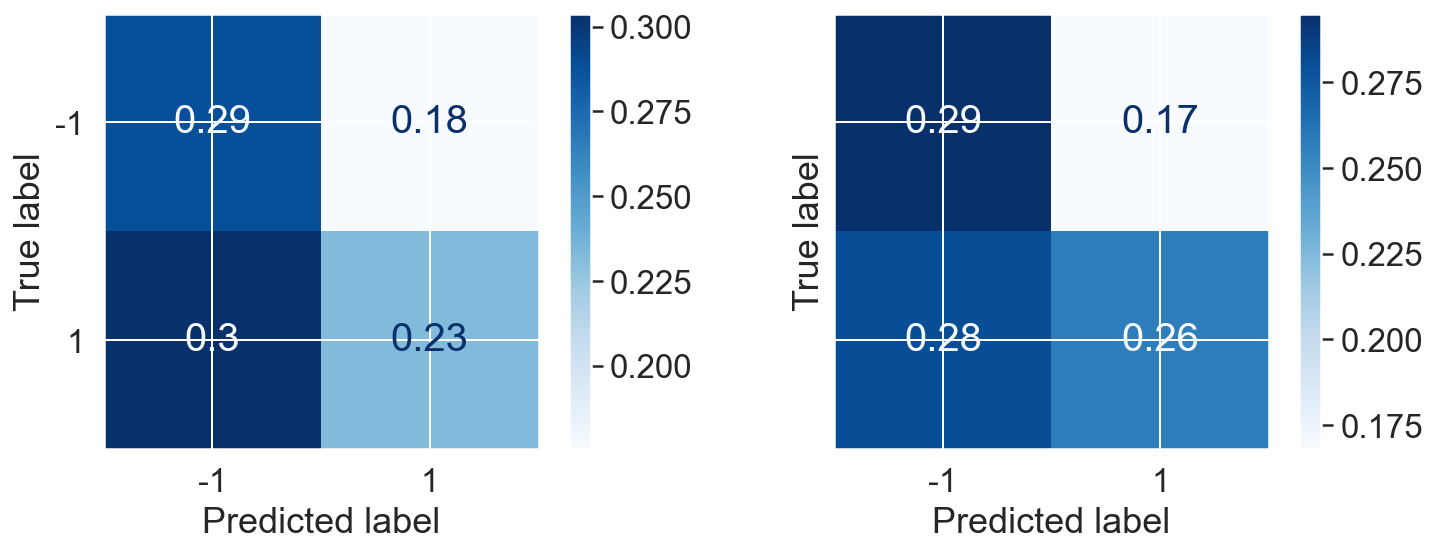

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(SVC1, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(SVC1, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

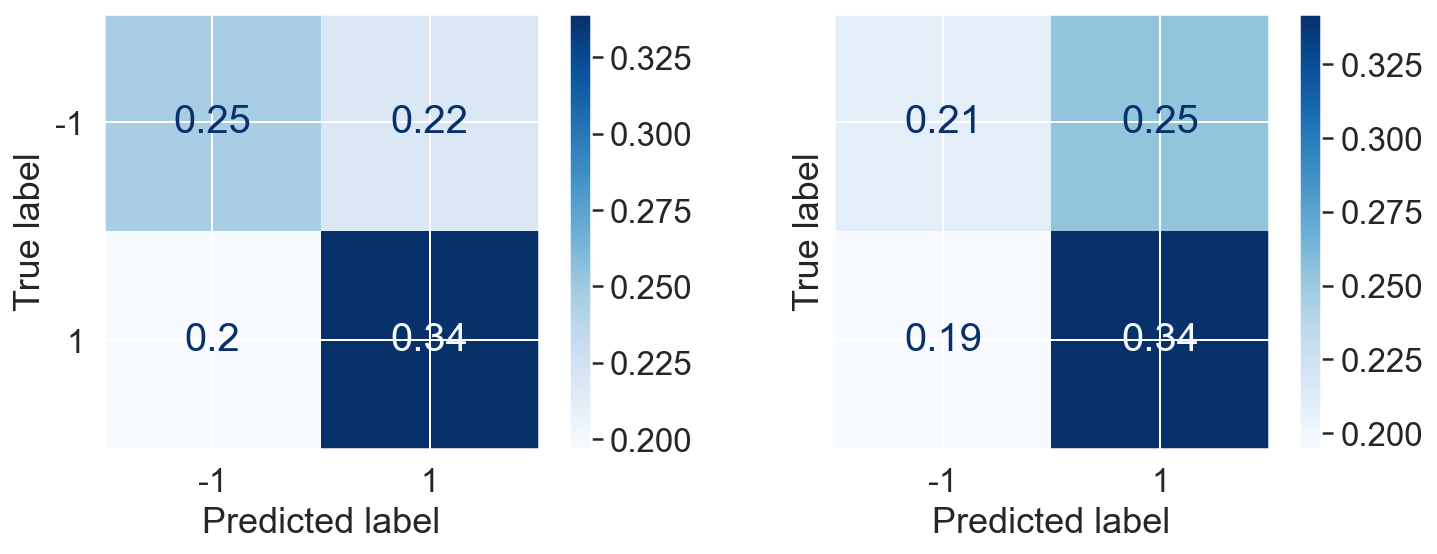

In [99]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(SVC2, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(SVC2, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [4]:
SVC3 = SVC()
gridsvm = GridSearchCV(SVC3, param_grid=params_svm, cv=5, n_jobs=-2,verbose=10)
gridsvm.fit(Xstd_train1, y_train)
gridsvm.best_estimator_

NameError: name 'SVC' is not defined

In [101]:
gridsvm.best_score_

0.5847975906229651

In [102]:
gridsvm.score(Xstd_test1,y_test)

0.6017699115044248

In [103]:
gridsvm.score(Xstd_train1,y_train)

0.7057522123893806

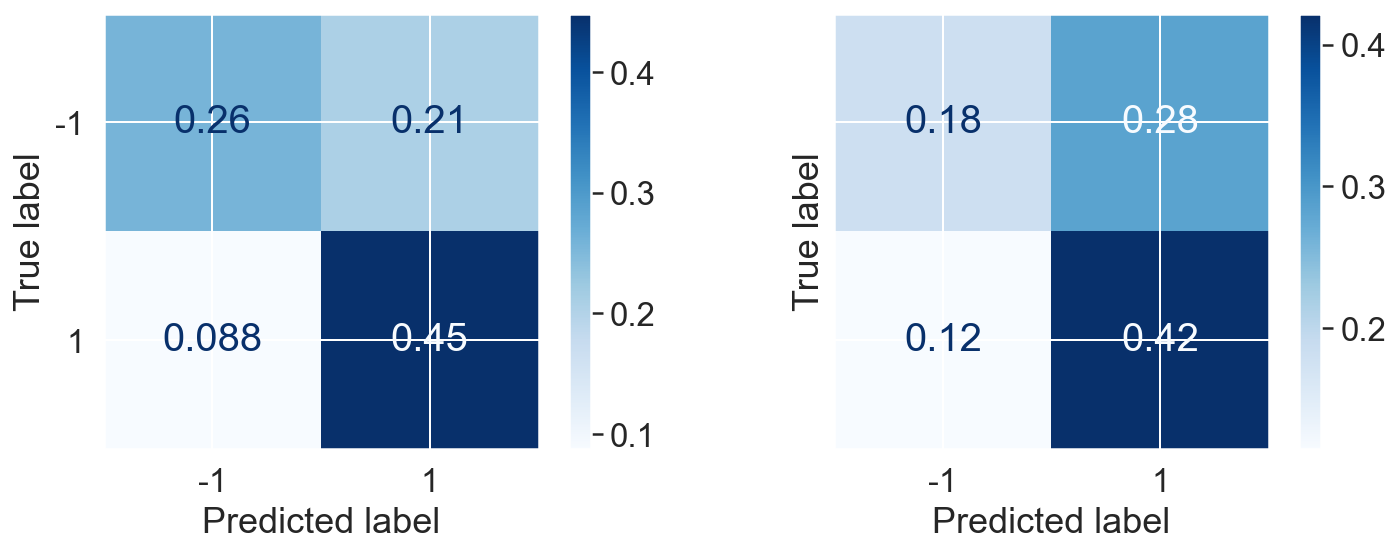

In [104]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gridsvm, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(gridsvm, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [ ]:
SVC4 = SVC(kernel='poly')
gridsvm2 = GridSearchCV(SVC4, param_grid=params_svm_poly, cv=5, n_jobs=-2,verbose=10)
gridsvm2.fit(Xstd_train1, y_train)
gridsvm2.best_estimator_

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0529s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1636s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 118 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 162 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 214 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Batch computation too slow (2.2696s.) Setting batch_size=1.
[Parallel(n_jobs=-2)]: Done 326 tasks      | elapsed:    9.1s


In [ ]:
gridsvm2.best_params_

In [ ]:
gridsvm2.best_score_

In [ ]:
gridsvm2.score(Xstd_test1,y_test)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gridsvm2, Xstd_train1, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(gridsvm2, Xstd_test1, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()